# Bayesian Hierarchical Modeling

This jupyter notebook accompanies the Bayesian Hierarchical Modeling lecture(s) delivered by Stephen Feeney as part of David Hogg's [Computational Data Analysis class](http://dwh.gg/FlatironCDA). As part of the lecture(s) you will be asked to complete a number of tasks, some of which will involve direct coding into the notebook; these sections are marked by task. This notebook requires numpy, matplotlib, scipy, [corner](https://github.com/sfeeney/bhm_lecture.git), [pystan](https://pystan.readthedocs.io/en/latest/getting_started.html) and pickle to run (the last two are required solely for the final task).

We start with imports...

In [1]:
from __future__ import print_function

# make sure everything we need is installed if running on Google Colab
def is_colab():
    try:
        cfg = get_ipython().config
        if cfg['IPKernelApp']['kernel_class'] == 'google.colab._kernel.Kernel':
            return True
        else:
            return False
    except NameError:
        return False
if is_colab():
    !pip install --quiet numpy matplotlib scipy corner pystan

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as mp
%matplotlib inline

... and immediately move to...

## Task 2

In which I ask you to write a Python function to generate a simulated Cepheid sample using the period-luminosity relation $m_{ij} = \mu_i + M^* + s\,\log p_{ij} + \epsilon(\sigma_{\rm int})$. For simplicity, assume Gaussian priors on everything, Gaussian intrinsic scatter and Gaussian measurement uncertainties. Assume only the first host has a distance modulus estimate.

In [2]:
# setup
n_gal = 2
n_star = 200
n_samples = 50000

# PL relation parameters
abs_bar = -26.0   # mean of standard absolute magnitude prior
abs_sig = 4.0     # std dev of standard absolute magnitude prior
s_bar = -1.0      # mean of slope prior
s_sig = 1.0       # std dev of slope prior
mu_bar = 30.0     # mean of distance modulus prior
mu_sig = 5.0      # std dev of distance modulus prior
m_sig_int = 0.05  # intrinsic scatter, assumed known

# uncertainties
mu_hat_sig = 0.01 # distance modulus measurement uncertainty
m_hat_sig = 0.02  # apparent magnitude measurement uncertainty

def simulate(n_gal, n_star, abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, m_sig_int, m_hat_sig):
    
    # draw CPL parameters from prior
    #abs_true = abs_bar
    #s_true = s_bar
    abs_true = abs_bar + npr.randn() * abs_sig
    s_true = s_bar + npr.randn() * s_sig
    
    # draw distance moduli from prior and measure one noisily
    # i've chosen to sort here so the closest galaxy is the one with the measured distance modulus
    mu_true = np.sort(mu_bar + npr.randn(n_gal) * mu_sig)
    mu_hat = mu_true[0] + npr.randn() * mu_hat_sig
    
    # draw log periods. these are assumed to be perfectly observed in this model, so they 
    # are simply a set of pre-specified numbers. i have chosen to generate new values with 
    # each simulation, drawn such that log-periods are uniformly drawn in the range 1-2 (i.e., 
    # 10 to 100 days). you can have these for free!
    lp_true = 1.0 + npr.rand(n_gal, n_star)
    
    # draw true apparent magnitudes. these are distributed around the Cepheid period-luminosity 
    # relation with Gaussian intrinsic scatter (mean 0, std dev m_sig_int)
    # observe noisily, all with the same measurement uncertainty m_hat_sig
    m_true = np.zeros((n_gal, n_star))
    for i in range(n_gal):
        m_true[i, :] = mu_true[i] + abs_true + s_true * lp_true[i, :] + npr.randn(n_star) * m_sig_int
    m_hat = m_true + npr.randn(n_gal, n_star) * m_hat_sig
    
    # return!
    return (abs_true, s_true, mu_true, lp_true, m_true, mu_hat, m_hat)

Let's check that the simulation generates something sane. A simple test that the magnitude measurements errors are correctly generated.

Text(0,0.5,'$N \\left(m_{ij} - \\hat{m}_{ij}\\right)$')

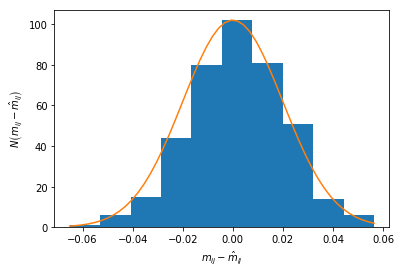

In [3]:
# simulate
abs_true, s_true, mu_true, lp_true, m_true, mu_hat, m_hat = \
    simulate(n_gal, n_star, abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, m_sig_int, m_hat_sig)

# plot difference between true and observed apparent magnitudes. this should be the 
# noise, which is Gaussian distributed with mean zero and std dev m_hat_sig
outs = mp.hist((m_true - m_hat).flatten())
dm_grid = np.linspace(np.min(outs[1]), np.max(outs[1]))
mp.plot(dm_grid, np.exp(-0.5 * (dm_grid/m_hat_sig) ** 2) * np.max(outs[0]))
mp.xlabel(r'$m_{ij} - \hat{m}_{ij}$')
mp.ylabel(r'$N \left(m_{ij} - \hat{m}_{ij}\right)$')

And another test that the intrinsic scatter is added as expected.

Text(0,0.5,'$N \\left(m_{ij} - \\hat{m}_{ij}\\right)$')

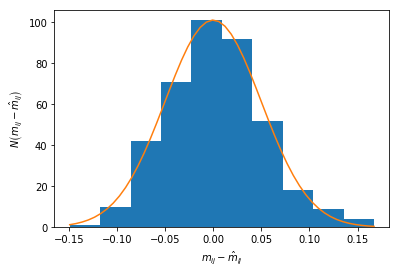

In [4]:
# plot difference between true apparent magnitudes and expected apparent 
# magnitude given a perfect (i.e., intrinsic-scatter-free) period-luminosity 
# relation. this should be the intrinsic scatter, which is Gaussian-
# distributed with mean zero and std dev m_sig_int
eps = np.zeros((n_gal, n_star))
for i in range(n_gal):
    eps[i, :] = mu_true[i] + abs_true + s_true * lp_true[i, :] - m_true[i, :]
outs = mp.hist(eps.flatten())
dm_grid = np.linspace(np.min(outs[1]), np.max(outs[1]))
mp.plot(dm_grid, np.exp(-0.5 * (dm_grid/m_sig_int) ** 2) * np.max(outs[0]))
mp.xlabel(r'$m_{ij} - \hat{m}_{ij}$')
mp.ylabel(r'$N \left(m_{ij} - \hat{m}_{ij}\right)$')

## Generalized Least Squares Demo

Coding up the [GLS estimator](https://en.wikipedia.org/wiki/Generalized_least_squares) is a little involved, so I've done it for you below. Note that, rather unhelpfully, I've done so in a different order than in the notes. When I get a chance I will re-write. For now, you can simply evaluate the cells and bask in the glory of the fastest inference you will ever do!

In [5]:
def gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, m_sig_int, m_hat_sig, \
            lp_true, priors=None):

    # setup
    # n_obs is one anchor constraint and one magnitude per Cepheid.
    # n_par is one mu per Cepheid host and 2 CPL params. if priors 
    # are used, we add on n_gal + 2 observations: one prior constraint 
    # on each host distance modulus and CPL parameter
    n_obs = n_gal * n_star + 1
    n_par = n_gal + 2
    if priors is not None:
        n_obs += n_gal + 2
    data = np.zeros(n_obs)
    design = np.zeros((n_obs, n_par))
    cov_inv = np.zeros((n_obs, n_obs))
    
    # anchor
    data[0] = mu_hat
    design[0, 0] = 1.0
    cov_inv[0, 0] = 1.0 / mu_hat_sig ** 2

    # Cepheids
    k = 1
    for i in range(0, n_gal):
        for j in range(0, n_star):

            data[k] = m_hat[i, j]
            design[k, i] = 1.0
            design[k, n_gal] = 1.0
            design[k, n_gal + 1] = lp_true[i, j]
            cov_inv[k, k] = 1.0 / (m_hat_sig ** 2 + m_sig_int ** 2)
            k += 1
    
    # and, finally, priors if desired
    if priors is not None:
        abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig = priors
        for i in range(n_gal):
            data[k] = mu_bar
            design[k, i] = 1.0
            cov_inv[k, k] = 1.0 / mu_sig ** 2
            k += 1
        data[k] = abs_bar
        design[k, n_gal] = 1.0
        cov_inv[k, k] = 1.0 / abs_sig ** 2
        k += 1
        data[k] = s_bar
        design[k, n_gal + 1] = 1.0
        cov_inv[k, k] = 1.0 / s_sig ** 2
        k += 1
        
    # fit and return
    destci = np.dot(design.transpose(), cov_inv)
    pars_cov = np.linalg.inv(np.dot(destci, design))
    pars = np.dot(np.dot(pars_cov, destci), data)
    res = data - np.dot(design, pars)
    dof = n_obs - n_par
    chisq_dof = np.dot(res.transpose(), np.dot(cov_inv, res))
    return pars, pars_cov, chisq_dof

In [6]:
gls_pars, gls_pars_cov, gls_chisq = gls_fit(n_gal, n_star, mu_hat, mu_hat_sig, m_hat, \
                                            m_sig_int, m_hat_sig, lp_true, \
                                            priors=[abs_bar, abs_sig, s_bar, s_sig, mu_bar, mu_sig])

In order to plot the outputs of the GLS fit we could draw a large number of samples from the resulting multivariate Gaussian posterior and pass them to something like [`corner`](https://corner.readthedocs.io/en/latest/); however, as we have analytic results we might as well use those directly. I've coded up something totally hacky here in order to do so. Information on how to draw confidence ellipses can be found in [Dan Coe's note](https://arxiv.org/pdf/0906.4123.pdf).

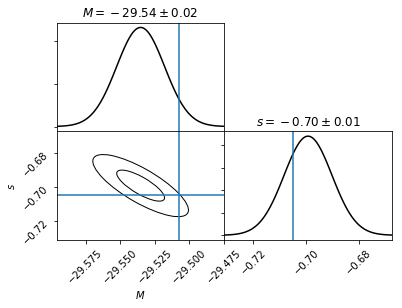

In [7]:
# this is a hacky function designed to transform the analytic GLS outputs
# into a corner.py style triangle plot, containing 1D and 2D marginalized
# posteriors
import scipy.stats as sps
import matplotlib.patches as mpp
def schmorner(par_mean, par_cov, par_true, par_label):
    
    # setup
    par_std = np.sqrt(np.diag(par_cov))
    x_min = par_mean[0] - 3.5 * par_std[0]
    x_max = par_mean[0] + 3.5 * par_std[0]
    y_min = par_mean[1] - 3.5 * par_std[1]
    y_max = par_mean[1] + 3.5 * par_std[1]
    fig, axes = mp.subplots(2, 2)
    
    # 1D marge
    x = np.linspace(x_min, x_max, 100)
    axes[0, 0].plot(x, sps.norm.pdf(x, par_mean[0], par_std[0]), 'k')
    axes[0, 0].axvline(par_true[0])
    axes[1, 0].axvline(par_true[0])
    axes[0, 0].set_xticklabels([])
    axes[0, 0].set_yticklabels([])
    axes[0, 0].set_xlim(x_min, x_max)
    axes[0, 0].set_title(par_label[0])
    axes[0, 0].set_title(par_label[0] + r'$=' + '{:6.2f}'.format(par_mean[0]) + \
                         r'\pm' + '{:4.2f}'.format(par_std[0]) + r'$')
    y = np.linspace(y_min, y_max, 100)
    axes[1, 1].plot(y, sps.norm.pdf(y, par_mean[1], par_std[1]), 'k')
    axes[1, 0].axhline(par_true[1])
    axes[1, 1].axvline(par_true[1])
    axes[1, 1].tick_params(labelleft=False)
    axes[1, 1].set_xlim(y_min, y_max)
    for tick in axes[1, 1].get_xticklabels():
        tick.set_rotation(45)
    axes[1, 1].set_title(par_label[1] + r'$=' + '{:5.2f}'.format(par_mean[1]) + \
                         r'\pm' + '{:4.2f}'.format(par_std[1]) + r'$')

    # 2D marge
    vals, vecs = np.linalg.eig(par_cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    w, h = 2 * np.sqrt(vals)
    ell = mpp.Ellipse(xy=par_mean, width=w, height=h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    ell = mpp.Ellipse(xy=par_mean, width=2*w, height=2*h,
                      angle=theta, color='k')
    ell.set_facecolor("none")
    axes[1, 0].add_artist(ell)
    axes[1, 0].set_xlim(x_min, x_max)
    axes[1, 0].set_ylim(y_min, y_max)
    for tick in axes[1, 0].get_xticklabels():
        tick.set_rotation(45)
    for tick in axes[1, 0].get_yticklabels():
        tick.set_rotation(45)
    axes[1, 0].set_xlabel(par_label[0])
    axes[1, 0].set_ylabel(par_label[1])
    fig.delaxes(axes[0, 1])
    fig.subplots_adjust(hspace=0, wspace=0)
    
test = schmorner(gls_pars[n_gal:], gls_pars_cov[n_gal:, n_gal:], \
                 [abs_true, s_true], [r'$M$', r'$s$'])
#
#lazy = npr.multivariate_normal(gls_pars[n_gal:], gls_pars_cov[n_gal:, n_gal:], n_samples)
#fig = corner.corner(samples.T, labels=[r"$M$", r"$s$"],
#                    show_titles=True, truths=[abs_bar, s_bar])

## Task 3B

Below I've written the majority of a Gibbs sampler to infer the hyper-parameters of the Cepheid PL relation from our simulated sample. One component is missing: drawing from the conditional distribution of the standard absolute magnitude, $M^*$. Please fill it in, using the results of whiteboard/paper Task 3A. 

In [8]:
def gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                 s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                 m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat):
    
    # storage
    abs_samples = np.zeros(n_samples)
    s_samples = np.zeros(n_samples)
    mu_samples = np.zeros((n_gal, n_samples))
    m_samples = np.zeros((n_gal, n_star, n_samples))
    
    # initialize sampler
    abs_samples[0] = abs_bar + npr.randn() * abs_sig
    s_samples[0] = s_bar + npr.randn() * s_sig
    mu_samples[:, 0] = mu_bar + npr.randn(n_gal) * mu_bar
    for i in range(n_gal):
        m_samples[i, :, 0] = mu_samples[i, 0] + abs_samples[0] + s_samples[0] * lp_true[i, :]
    
    # sample!
    for i in range(1, n_samples):
        
        # sample abs mag
        abs_sig_pl = m_sig_int / np.sqrt(n_gal * n_star)
        abs_bar_pl = 0.0
        for j in range(n_gal):
            abs_bar_pl += np.sum(m_samples[j, :, i - 1] - mu_samples[j, i - 1] - s_samples[i - 1] * lp_true[j, :])
        abs_bar_pl /= (n_gal * n_star)
        abs_std = np.sqrt((abs_sig * abs_sig_pl) ** 2 / (abs_sig ** 2 + abs_sig_pl ** 2))
        abs_mean = (abs_sig ** 2 * abs_bar_pl + abs_sig_pl ** 2 * abs_bar) / \
                   (abs_sig ** 2 + abs_sig_pl ** 2)
        abs_samples[i] = abs_mean + npr.randn() * abs_std
        
        # sample slope
        s_sig_pl = m_sig_int / np.sqrt(np.sum(lp_true ** 2))
        s_bar_pl = 0.0
        for j in range(n_gal):
            s_bar_pl += np.sum((m_samples[j, :, i - 1] - mu_samples[j, i - 1] - abs_samples[i]) * lp_true[j, :])
        s_bar_pl /= np.sum(lp_true ** 2)
        s_std = np.sqrt((s_sig * s_sig_pl) ** 2 / (s_sig ** 2 + s_sig_pl ** 2))
        s_mean = (s_sig ** 2 * s_bar_pl + s_sig_pl ** 2 * s_bar) / \
                 (s_sig ** 2 + s_sig_pl ** 2)
        s_samples[i] = s_mean + npr.randn() * s_std
        
        # sample apparent magnitudes
        for j in range(n_gal):
            m_mean_pl = mu_samples[j, i - 1] + abs_samples[i] + s_samples[i] * lp_true[j, :]
            m_std = np.sqrt(m_sig_int ** 2 * m_hat_sig ** 2 / (m_sig_int ** 2 + m_hat_sig ** 2))
            m_mean = (m_sig_int ** 2 * m_hat[j, :] + m_hat_sig ** 2 * m_mean_pl) / (m_sig_int ** 2 + m_hat_sig ** 2)
            m_samples[j, :, i] = m_mean + npr.randn(n_star) * m_std
            
        # sample distance moduli
        mu_sig_pl = m_sig_int / np.sqrt(n_star)
        mu_bar_pl = np.mean(m_samples[0, :, i] - abs_samples[i] - s_samples[i] * lp_true[0, :])
        mu_var = 1.0 / (1.0 / mu_sig ** 2 + 1.0 / mu_hat_sig ** 2 + 1.0 / mu_sig_pl ** 2)
        mu_mean = (mu_bar / mu_sig ** 2 + mu_hat / mu_hat_sig ** 2 + mu_bar_pl / mu_sig_pl ** 2) * mu_var
        mu_samples[0, i] = mu_mean + npr.randn() * np.sqrt(mu_var)
        for j in range(1, n_gal):
            mu_sig_pl = m_sig_int / np.sqrt(n_star)
            mu_bar_pl = np.mean(m_samples[j, :, i] - abs_samples[i] - s_samples[i] * lp_true[j, :])
            mu_std = (mu_sig * mu_sig_pl) ** 2 / (mu_sig ** 2 + mu_sig_pl ** 2)
            mu_mean = (mu_sig ** 2 * mu_bar_pl + mu_sig_pl ** 2 * mu_bar) / \
                      (mu_sig ** 2 + mu_sig_pl ** 2)
            mu_samples[j, i] = mu_mean + npr.randn() * mu_std
        
    return (abs_samples, s_samples, mu_samples, m_samples)

Now let's sample, setting aside the first half of the samples as warmup.

In [9]:
all_samples = gibbs_sample(n_samples, n_gal, n_star, abs_bar, abs_sig, \
                           s_bar, s_sig, mu_bar, mu_sig, mu_hat_sig, \
                           m_sig_int, m_hat_sig, mu_hat, lp_true, m_hat)
n_warmup = int(n_samples / 2)
g_samples = [samples[n_warmup:] for samples in all_samples]

Let's make sure that the absolute magnitude is being inferred as expected. First, generate a trace plot of the absolute magnitude samples (the first entry in `g_samples`), overlaying the ground truth. Then print out the mean and standard deviation of the marginalized absolute magnitude posterior. Recall that marginalizing is as simple as throwing away the samples of all other parameters.

Truth -29.51; inferred -29.53 +/- 0.02


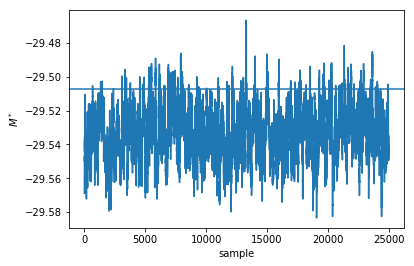

In [10]:
mp.plot(g_samples[0])
mp.axhline(abs_true)
mp.xlabel('sample')
mp.ylabel(r'$M^*$')
print('Truth {:6.2f}; inferred {:6.2f} +/- {:4.2f}'.format(abs_true, np.mean(g_samples[0]), np.std(g_samples[0])))

Now let's generate some marginalized parameter posteriors (by simply discarding all samples of the latent parameters) using DFM's [`corner`](https://corner.readthedocs.io/en/latest/) package. Note the near identical nature of this plot to the `schmorner` plot we generated above.

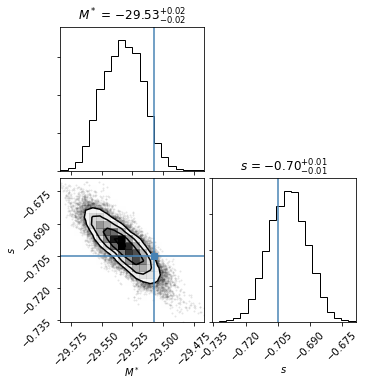

In [11]:
import corner
samples = np.stack((g_samples[0], g_samples[1]))
fig = corner.corner(samples.T, labels=[r"$M^*$", r"$s$"],
                    show_titles=True, truths=[abs_true, s_true])

## Task 4

The final task is to write a [Stan model](https://pystan.readthedocs.io/en/latest/getting_started.html) to infer the parameters of the period-luminosity relation. I've coded up the other two blocks required (`data` and `parameters`), so all that is required is for you to write the joint posterior (factorized into its individual components) in Stan's sampling-statement-based syntax. Essentially all you need are Gaussian sampling statements (`abs_true ~ normal(abs_bar, abs_sig);`) and for loops (`for(i in 1: n_gal){...}`).

When you evaluate this cell, Stan will translate your model into `c++` code and compile it. We will then pickle the compiled model so you can re-use it rapidly without recompiling. To do so, please set `recompile = False` in the notebook.

In [12]:
import sys
import pystan as ps
import pickle

stan_code = """
data {
    int<lower=0> n_gal;
    int<lower=0> n_star;
    real mu_hat;
    real mu_hat_sig;
    real m_hat[n_gal, n_star];
    real m_hat_sig;
    real m_sig_int;
    real lp_true[n_gal, n_star];
    real abs_bar;
    real abs_sig;
    real s_bar;
    real s_sig;
    real mu_bar;
    real mu_sig;
}
parameters {
    real mu_true[n_gal];
    real m_true[n_gal, n_star];
    real abs_true;
    real s_true;
}
model {
    // priors
    abs_true ~ normal(abs_bar, abs_sig);
    s_true ~ normal(s_bar, s_sig);
    mu_true ~ normal(mu_bar, mu_sig);
    
    // whatevers
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_true[i, j] ~ normal(mu_true[i] + abs_true + s_true * lp_true[i, j], m_sig_int);
        }
    }
    
    // likelihoods
    mu_hat ~ normal(mu_true[1], mu_hat_sig);
    for(i in 1: n_gal){
        for(j in 1: n_star){
            m_hat[i, j] ~ normal(m_true[i, j], m_hat_sig);
        }
    }
}
"""
n_samples_stan = 5000
recompile = False
pkl_fname = 'bhms_stan_model_v{:d}p{:d}p{:d}.pkl'.format(sys.version_info[0], \
                                                         sys.version_info[1], \
                                                         sys.version_info[2])
if recompile:
    stan_model = ps.StanModel(model_code=stan_code)
    with open(pkl_fname, 'wb') as f:
        pickle.dump(stan_model, f)
else:
    try:
        with open(pkl_fname, 'rb') as f:
            stan_model = pickle.load(f)
    except EnvironmentError:
        print('ERROR: pickled Stan model (' + pkl_fname + ') not found. ' + \
              'Please set recompile = True')

Now let's sample...

In [13]:
stan_data = {'n_gal': n_gal, 'n_star': n_star, 'mu_hat': mu_hat, 'mu_hat_sig': mu_hat_sig, \
             'm_hat': m_hat, 'm_hat_sig': m_hat_sig, 'm_sig_int': m_sig_int, 'lp_true': lp_true, \
             'abs_bar': abs_bar, 'abs_sig': abs_sig, 's_bar': s_bar, 's_sig': s_sig, \
             'mu_bar': mu_bar, 'mu_sig': mu_sig}
fit = stan_model.sampling(data=stan_data, iter=n_samples_stan, chains=4)

/Users/sfeeney/Software_Packages/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


... print out Stan's posterior summary (note this is for _all_ parameters)...

In [14]:
samples = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_ab41b39e55c2f57c74acf30e86ea4ea5.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_true[0]     27.77  1.3e-4 9.9e-3  27.76  27.77  27.77  27.78  27.79   5474    1.0
mu_true[1]      35.6  1.6e-4   0.01  35.58  35.59   35.6  35.61  35.62   5155    1.0
m_true[0,0]    -2.48  1.9e-4   0.02  -2.52   -2.5  -2.48  -2.47  -2.45  10000    1.0
m_true[1,0]     4.94  1.9e-4   0.02   4.91   4.93   4.94   4.96   4.98  10000    1.0
m_true[0,1]    -2.94  1.8e-4   0.02  -2.98  -2.95  -2.94  -2.93  -2.91  10000    1.0
m_true[1,1]     5.28  1.8e-4   0.02   5.25   5.27   5.28    5.3   5.32  10000    1.0
m_true[0,2]    -2.85  1.9e-4   0.02  -2.89  -2.86  -2.85  -2.84  -2.81  10000    1.0
m_true[1,2]     5.01  1.9e-4   0.02   4.97    5.0   5.01   5.02   5.05  10000    1.0
m_true[0,3]    -2.73  1.9e-4   0.02  -2.77  -

... and plot the marginalized posterior of the PL parameters, as with the Gibbs sampler.

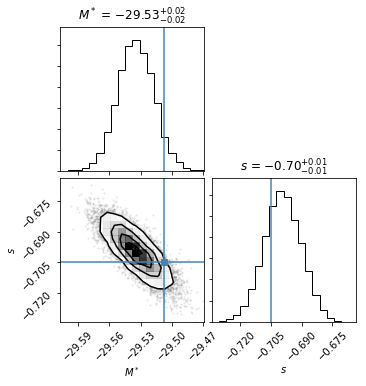

In [15]:
c_samples = np.stack((samples['abs_true'], samples['s_true']))
fig = corner.corner(c_samples.T, labels=[r"$M^*$", r"$s$"],
                    show_titles=True, truths=[abs_true, s_true])

Our work here is done!